<a href="https://colab.research.google.com/github/shekharsharma100001/Data-Generation-using-Transformer/blob/main/data_gen_using_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load and Label All Data

In [2]:
import os
import pandas as pd
import numpy as np

def load_folder_data(folder_path, label):
    data = []
    for file in os.listdir(folder_path):
        if file.endswith('.txt'):
            file_path = os.path.join(folder_path, file)
            df = pd.read_csv(file_path, sep='\t', header=None)
            df = df.iloc[:, 1:]
            if df.shape == (300, 8):  # Ensure proper shape
                data.append((df.values, label))
    return data

# Set your actual paths here
hq_path = '/content/drive/MyDrive/dataset/HQ_Coffee'
aq_path = '/content/drive/MyDrive/dataset/AQ_Coffee'
lq_path = '/content/drive/MyDrive/dataset/LQ_Coffee'

# Load all files with class labels
hq_data = load_folder_data(hq_path, label=2)
aq_data = load_folder_data(aq_path, label=1)
lq_data = load_folder_data(lq_path, label=0)

all_data = hq_data + aq_data + lq_data


#Normalize All Sensor Data

In [3]:
from sklearn.preprocessing import StandardScaler

X_all = [sample[0] for sample in all_data]
X_stacked = np.vstack(X_all)  # Shape: (N × 300, 8)

scaler = StandardScaler()
scaler.fit(X_stacked)

# Apply normalization
normalized_data = [(scaler.transform(x), label) for x, label in all_data]


#Prepare Tensors and DataLoader

In [8]:
import torch
from torch.utils.data import TensorDataset, DataLoader

X_tensor = torch.stack([torch.tensor(x, dtype=torch.float32) for x, _ in normalized_data])  # (num_samples, 300, 8)
y_tensor = torch.tensor([label for _, label in normalized_data])  # (num_samples,)

# Create DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=8, shuffle=True)



#Define Transformer Model

In [9]:
import torch.nn as nn

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim=8, d_model=64, nhead=4, num_layers=3):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True  # ✅ This is key to fix the warning and permute issue
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_proj = nn.Linear(d_model, input_dim)

    def forward(self, x):  # x: (B, 300, 8)
        x = self.input_proj(x)
        x = self.encoder(x)
        return self.output_proj(x)


#Train the Transformer

In [10]:
model = TimeSeriesTransformer()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # 🔽 lower LR
criterion = nn.MSELoss()

for epoch in range(30):
    total_loss = 0
    model.train()

    for x_batch, _ in loader:  # x_batch: (B, 300, 8)
        output = model(x_batch)
        loss = criterion(output, x_batch)

        if torch.isnan(loss):
            print("⚠️ Skipping NaN loss")
            continue

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f}")


Epoch 1 | Loss: 8.3431
Epoch 2 | Loss: 3.2461
Epoch 3 | Loss: 2.2743
Epoch 4 | Loss: 1.4654
Epoch 5 | Loss: 1.3353
Epoch 6 | Loss: 1.0545
Epoch 7 | Loss: 0.9371
Epoch 8 | Loss: 0.7868
Epoch 9 | Loss: 0.7134
Epoch 10 | Loss: 0.6382
Epoch 11 | Loss: 0.5785
Epoch 12 | Loss: 0.5609
Epoch 13 | Loss: 0.5086
Epoch 14 | Loss: 0.5456
Epoch 15 | Loss: 0.4637
Epoch 16 | Loss: 0.4487
Epoch 17 | Loss: 0.4494
Epoch 18 | Loss: 0.4634
Epoch 19 | Loss: 0.3913
Epoch 20 | Loss: 0.3927
Epoch 21 | Loss: 0.3814
Epoch 22 | Loss: 0.3657
Epoch 23 | Loss: 0.3479
Epoch 24 | Loss: 0.3243
Epoch 25 | Loss: 0.3556
Epoch 26 | Loss: 0.3124
Epoch 27 | Loss: 0.3392
Epoch 28 | Loss: 0.3126
Epoch 29 | Loss: 0.2758
Epoch 30 | Loss: 0.3021


#Generate Synthetic Sample

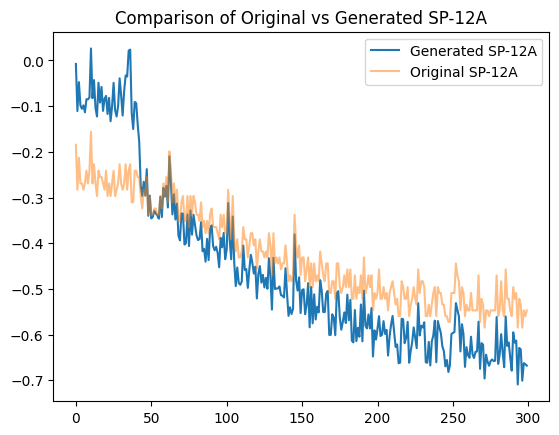

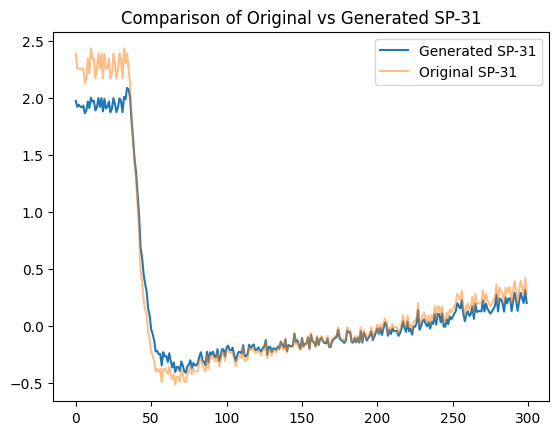

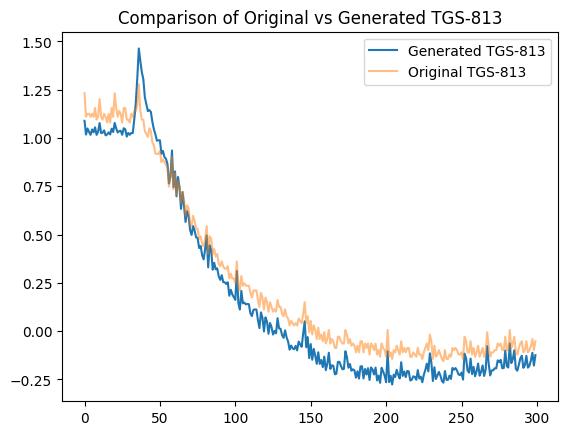

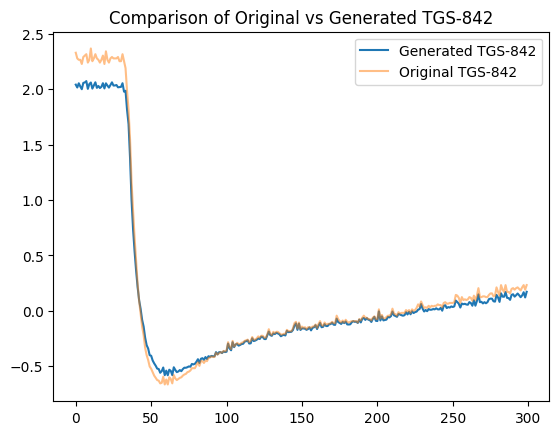

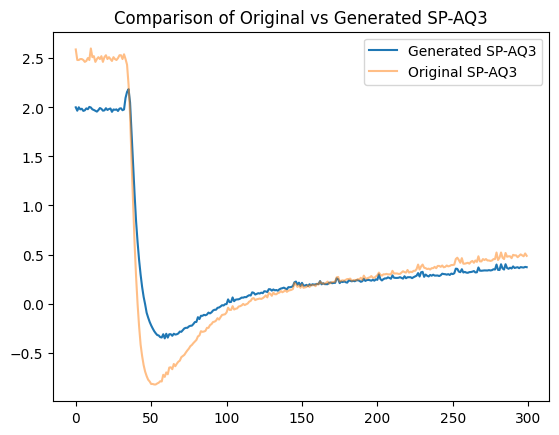

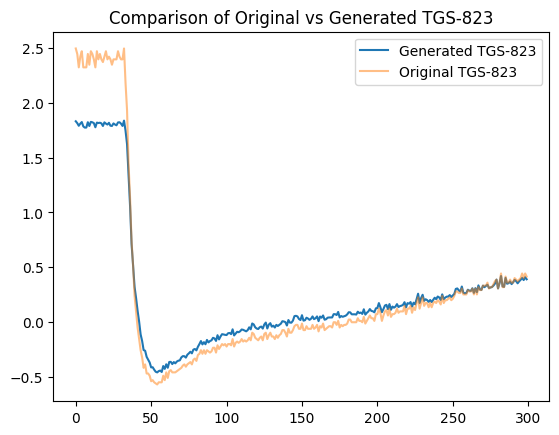

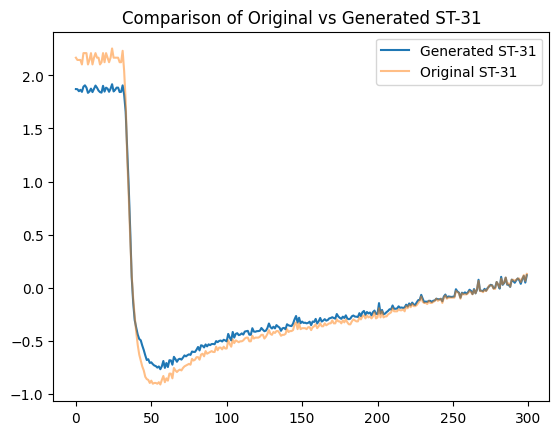

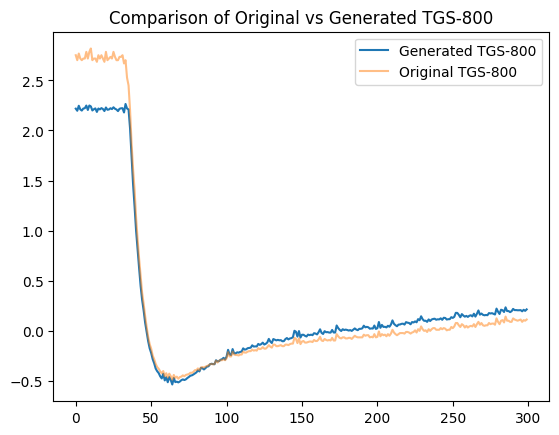

In [12]:
model.eval()
with torch.no_grad():
    sample_idx = 0  # Choose any real input
    x_real = X_tensor[sample_idx].unsqueeze(1)  # shape: (300, 1, 8)
    generated = model(x_real).squeeze(1).numpy()  # shape: (300, 8)

# Plot example
import matplotlib.pyplot as plt
SENSOR_COLUMNS = ["SP-12A", "SP-31", "TGS-813", "TGS-842", "SP-AQ3", "TGS-823", "ST-31", "TGS-800"]
for i in range(8):
    plt.plot(generated[:, i], label=f'Generated {SENSOR_COLUMNS[i]}')
    plt.plot(X_tensor[sample_idx, :, i].numpy(), label=f'Original {SENSOR_COLUMNS[i]}', alpha=0.5)
    plt.legend()
    plt.title(f"Comparison of Original vs Generated {SENSOR_COLUMNS[i]}")
    plt.show()


# plt.plot(generated[:, 7], label='Generated Sensor 1')
# plt.plot(X_tensor[sample_idx, :, 7].numpy(), label='Original Sensor 1', alpha=0.5)
# plt.legend()
# plt.title("Comparison of Original vs Generated Sensor Signal")
# plt.show()
